# StyleGAN

Generative adversarial networks (GANs) have been around since [2014](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), and have shown steady progress in developing models that can generate realistic images. GANs work by creating two competing networks - a Generator and a Discriminator. The Generator maps a latent vector to an image. The Discriminator evaluates the quality of the generated image relative to some existing dataset. Over the training process, the generated images converge from random noise to images that resemble the target dataset.

GANs ideally learn to generate images that *look like* the target dataset without actually *copying* the target dataset. GANs learn some probability distribution over the target dataset and generate images that look like the *could have* come from that dataset, without actually memorizing and regurgitating images from the dataset. In a perfect world, each different latent vector maps to a different output, allowing for infinitely many generated images. Latent inputs that are close in vector space generate images that are similar but not exactly the same. In practice however, GANs can suffer from what is known as Mode Collapse, where the Generator converges to only generating a small, finite set of outputs regardless of the input vector.

GANs also suffer from stability problems and are notoriously hard to train. Historically, generating larger images while maintaining the quality and diversity possible at lower scales has proven challenging. Various techniques like [Progressive Growing](https://arxiv.org/abs/1710.10196), careful [weight clipping](https://arxiv.org/abs/1701.07875), [regularization strategies](https://arxiv.org/abs/1704.00028) and [normalization approaches](https://arxiv.org/abs/1802.05957) have been developed to improve the stability of training GANs.

Another outstanding mystery in GAN-world is understanding how the latent vector maps to the output. Specifically, what parts of the latent input control aspects of the latent output. How can we break apart the latent vector and disentangle the latent representation to have finer control over the resulting image?

In 2018, Nvidia released [StyleGAN](https://arxiv.org/pdf/1812.04948.pdf), a new type of GAN architecture that builds on the history of GAN research to create a fundamentally different kind of generator that tackles the problem of understanding the properties of the latent vector.

Instead of starting with a latent vector, StyleGAN first sends the latent vector through a mapping network consisting of several fully connected layers. This allows the generator to learn an intermediate latent space that is best for generating images. The intermediate latent vector is then injected into the generator at different layers, rather than just being a starting template.

![](media/stylegan.png)

The key finding of StyleGAN was that adding the intermediate latent vector at different layers of the generator caused different effects on the output image. Injection at early layers of the generator influenced major details of the image, while injection at later layers influenced finer details. The result is that the StyleGAN generator can be used to blend different latent vectors. The exact method by which the intermediate latent vector is added to the generator is discussed later.

![](media/stylegan_mixing.jpg)

StyleGAN is able to train with good stability to images as large as 1024x1024 by training with [progressive growing](https://arxiv.org/pdf/1710.10196.pdf). We start training on 4x4 images. After some time, we grow to 8x8, then 16x16 and so on. When we grow the model, there's a small issue. We now have a new layer that converts a tensor of activations to a 3 channel RGB image. Since this new layer is untrained, it likely produces poor quality images. To prevent this from messing up training, the new RGB layer is phased in.

![](media/rgb.png)

So that's a quick overview. Let’s start looking at the model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
from fastai.callbacks import *
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
path = Path('G:/FFHQ/images')

In [4]:
def get_data(bs, size, path, num_workers, noise_size=512):
    return (GANItemList.from_folder(path, noise_sz=noise_size)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs, num_workers=num_workers)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [5]:
# I resized the main dataset into individual sets for each image size
# This has a noticeable effect on training speed
data_4 = get_data(256, 4, path/'images_4', 8)
data_8 = get_data(256, 8, path/'images_8', 8)
data_16 = get_data(128, 16, path/'images_16', 8)
data_32 = get_data(128, 32, path/'images_32', 8)
data_64 = get_data(48, 64, path/'images_64', 8)
data_128 = get_data(22, 128, path/'images_128', 8)
data_256 = get_data(10, 256, path/'images_256', 8)
data_512 = get_data(4, 512, path/'images_512', 8)

## StyleGAN Fundamentals

First we start with the basic building blocks of the StyleGAN. StyleGAN uses Equalized Learning Rates for all layers. This is a technique from the [Progressive GAN](https://arxiv.org/pdf/1710.10196.pdf) paper.

Layers are typically initialized to a careful distribution to ensure the initial output of the untrained layer has approximately mean zero and standard deviation one. This is to avoid having activations or gradients vanish or explode early in training. Kaiming initialization scales all values by a factor of $c = \frac{\sqrt2}{W}$ where $W$ is the length of the weight matrix along one dimension.

Equalized learning rates applies the Kaiming constant dynamically during runtime, rather than just at the initialization. The reason for doing this is, to quote the paper, "somewhat subtle". Many optimization algorithms normalize gradients in such a way that the scale of the gradient update independent of the scale of the parameter being updated. This leads to some small parameters receiving updates that are too large, and large parameters receiving updates that are too small. The effect is that the learning rate is too high for some parameters and too low for others, leading to instability. The Equalized Learning Weights technique applies Kaiming scaling on every forward pass to ensure all the weights in the model are of a similar range.

In [6]:
class EqualLR:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * math.sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module

In [7]:
class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)

This is the standard convolutional block for the model. It consists of two convolutional layers with leaky relu activations. This sort of convolutional block will be used in the discriminator.

In [8]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        padding,
        kernel_size2=None,
        padding2=None,
        pixel_norm=True,
        spectral_norm=False,
    ):
        super().__init__()

        pad1 = padding
        pad2 = padding
        if padding2 is not None:
            pad2 = padding2

        kernel1 = kernel_size
        kernel2 = kernel_size
        if kernel_size2 is not None:
            kernel2 = kernel_size2

        self.conv = nn.Sequential(
            EqualConv2d(in_channel, out_channel, kernel1, padding=pad1),
            nn.LeakyReLU(0.2),
            EqualConv2d(out_channel, out_channel, kernel2, padding=pad2),
            nn.LeakyReLU(0.2),
        )

    def forward(self, input):
        out = self.conv(input)

        return out

For the generator, we alter the convolutional block with instance normalization. This is where the StyleGAN gets its style. Rather than normalizing activations by Batch Normalization, StyleGAN uses normalization with a learned affine transformation generated from the latent vector.

First the input activations are normalized by the mean and standard deviation of the activations. Then the input vector, mapped to latent space by a series of fully connected layers, is put through a linear layer that outputs two vectors with length corresponding to the number of channels in the activation tensor being normalized. These output vectors are learned affine transformations of the activations.

The full normalization is given by:

$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$

Where $\gamma$ and $\beta$ are the parameters generated from the latent vector.

In a nutshell, StyleGAN works by putting the intermediate latent vector through a linear layer that generates parameters used to shift and scale activations at each layer of the network. Each layer has its own linear layer to process the intermediate latent vector into scaling parameters, so each layer can learn to use the intermediate latent vector in different ways.

In [9]:
class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, in_channel, style_dim):
        super().__init__()

        self.norm = nn.InstanceNorm2d(in_channel)
        self.style = EqualLinear(style_dim, in_channel * 2)

        self.style.linear.bias.data[:in_channel] = 1
        self.style.linear.bias.data[in_channel:] = 0

    def forward(self, input, style):
        style = self.style(style).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta

        return out

StyleGAN also injects noise at each convolutional layer. This noise gives variation to the fine details of the output image. In the StyleGAN paper this manifested as adding variety to things like specific locks of hair or facial wrinkles.

The noise itself is drawn from a random normal distribution. The noise vector is then multiplied by a learned weight and added to the activations at each layer.

In [10]:
class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, noise):
        return image + self.weight * noise

The StyleGAN replaces using a latent vector as input to injecting the latent vector at each layer of the model. So what does the model use as the initial input for the generator?

StyleGAN uses a constant input that is learned over the course of training. This is really just a chunk of numbers to get the model started. All the variation in style comes from the latent vector injected throughout the model.

In [11]:
class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out

This is the basic convolutional block for the generator. The layer consists of two `Conv, Noise Injection, AdaIN, Leaky Relu` blocks.

In [12]:
class StyledConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size=3,
        padding=1,
        style_dim=512,
        initial=False,
    ):
        super().__init__()

        if initial:
            self.conv1 = ConstantInput(in_channel)

        else:
            self.conv1 = EqualConv2d(
                in_channel, out_channel, kernel_size, padding=padding
            )

        self.noise1 = equal_lr(NoiseInjection(out_channel))
        self.adain1 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu1 = nn.LeakyReLU(0.2)

        self.conv2 = EqualConv2d(out_channel, out_channel, kernel_size, padding=padding)
        self.noise2 = equal_lr(NoiseInjection(out_channel))
        self.adain2 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu2 = nn.LeakyReLU(0.2)

    def forward(self, input, style, noise):
        out = self.conv1(input)
        out = self.noise1(out, noise)
        out = self.adain1(out, style)
        out = self.lrelu1(out)

        out = self.conv2(out)
        out = self.noise2(out, noise)
        out = self.adain2(out, style)
        out = self.lrelu2(out)

        return out

With the styled conv block, we can create the generator for our network. The core of the network is the `progression` block, which upscales the constant input to a size of up to 16x1024x1024. The `to_rgb` stack contains EqualConv layers which pair with every layer in the `progression` block to convert the activations from `progression` into 3 channel RGB images.

The model takes as main inputs some style, which will be created by the mapping network, and some random noise. The step parameter controls how far through the `progression` stack we move before exiting to the `to_rgb` stack. The alpha parameter controls blending between a given `to_rgb` layer and the previous `to_rgb` layer.

The forward pass supports style mixing regularization. From the StyleGAN paper, this was shown to train the model to use the style injected at a given layer, and not rely on style inputs from previous layers. This made the effect of style mixing at different layers more dramatic. A `mixing_range` can be passed to control when styles are mixed.

In [13]:
class Generator(nn.Module):
    def __init__(self, code_dim):
        super().__init__()

        self.progression = nn.ModuleList(
            [
                StyledConvBlock(512, 512, 3, 1, initial=True), # 4x4
                StyledConvBlock(512, 512, 3, 1), # 8x8
                StyledConvBlock(512, 512, 3, 1), # 16x16
                StyledConvBlock(512, 512, 3, 1), # 32x32
                StyledConvBlock(512, 256, 3, 1), # 64x64
                StyledConvBlock(256, 128, 3, 1), # 128x128
                StyledConvBlock(128, 64, 3, 1), # 256x256
                StyledConvBlock(64, 32, 3, 1), # 512x512
                StyledConvBlock(32, 16, 3, 1), # 1024x1024
            ]
        )

        self.to_rgb = nn.ModuleList(
            [
                EqualConv2d(512, 3, 1), # 4x4
                EqualConv2d(512, 3, 1), # 8x8
                EqualConv2d(512, 3, 1), # 16x16
                EqualConv2d(512, 3, 1), # 32x32
                EqualConv2d(256, 3, 1), # 64x64
                EqualConv2d(128, 3, 1), # 128x128
                EqualConv2d(64, 3, 1), # 256x256
                EqualConv2d(32, 3, 1), # 512x512
                EqualConv2d(16, 3, 1), # 1024x1024
            ]
        )
        
    def forward(self, style, noise, step=0, alpha=-1, mixing_range=(-1, -1)):
        out = noise[0]

        if len(style) < 2:
            inject_index = [len(self.progression) + 1]

        else:
            inject_index = random.sample(list(range(step)), len(style) - 1)

        crossover = 0

        for i, (conv, to_rgb) in enumerate(zip(self.progression, self.to_rgb)):
            if mixing_range == (-1, -1):
                if crossover < len(inject_index) and i > inject_index[crossover]:
                    crossover = min(crossover + 1, len(style))

                style_step = style[crossover]

            else:
                if mixing_range[0] <= i <= mixing_range[1]:
                    style_step = style[1]

                else:
                    style_step = style[0]

            if i > 0 and step > 0:
                upsample = F.interpolate(
                    out, scale_factor=2, mode='bilinear', align_corners=False
                )
                out = conv(upsample, style_step, noise[i])

            else:
                out = conv(out, style_step, noise[i])

            if i == step:
                out = to_rgb(out)

                if i > 0 and alpha > 0:
                    skip_rgb = self.to_rgb[i - 1](upsample)
                    out = alpha * skip_rgb + (1 - alpha) * out

                break

        return out

Now we can create the entire generator network. The `StyledGenerator` class contains the linear mapping network that creates style vectors from random vectors. We also include a PixelNorm layer at the start to normalize the random vector. The full generator also stores the current `step` of the model and `alpha` for RGB mixing as attributes.

The forward pass generates style vectors from the inputs and includes possible random shuffling of style vectors for mixing regularization. Noise can be explicitly passed or randomly generated during the forward pass.

A `mean_style` can also be passed to enable truncation via the `style_weight` parameter.

The full generator has a `grow_model` function which can be used to dynamically control the size of the image generated and the degree of RGB mixing.

In [14]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

In [15]:
class StyledGenerator(nn.Module):
    def __init__(self, code_dim=512, n_mlp=8):
        super().__init__()

        self.generator = Generator(code_dim)

        layers = [PixelNorm()]
        for i in range(n_mlp):
            layers.append(EqualLinear(code_dim, code_dim))
            layers.append(nn.LeakyReLU(0.2))

        self.style = nn.Sequential(*layers)
        
        self.step = 0
        self.alpha = 0

    def forward(self, input, noise=None, mean_style=None, style_weight=0, mixing_range=(-1, -1), mixing=True):
        
        bs, ch, _, _ = input.shape
        input = input.view(bs, ch)
        
        if self.step < 1:
            mixing=False
        
        if mixing and random.random() < 0.9:
            shuffle = torch.randperm(input.size(0)).to(input.device)
            input = [input, input[shuffle]]
        else:
            input = [input]  
        
        styles = []

        for i in input:
            styles.append(self.style(i))

        batch = input[0].shape[0]

        if noise is None:
            noise = []

            for i in range(self.step + 1):
                size = 4 * 2 ** i
                noise.append(torch.randn(batch, 1, size, size, device=input[0].device))

        if mean_style is not None:
            styles_norm = []

            for style in styles:
                styles_norm.append(mean_style + style_weight * (style - mean_style))

            styles = styles_norm

        return self.generator(styles, noise, self.step, self.alpha, mixing_range=mixing_range)

    def mean_style(self, input):
        style = self.style(input).mean(0, keepdim=True)

        return style
        
    def grow_model(self, step=None, alpha=None):
        if step:
            self.step = step
        else:
            self.step += 1
            
        if alpha is not None:
            self.alpha = alpha
        else:
            self.alpha = 1

The Discriminator mirrors the generator. EqualConv blocks take in a 3 channel RGB image and project it to some higher channel tensor. Then a `progression` stack convolves the tensor down. The same step and alpha logic applies.

There's also a funny `actual` parameter in the forward loop. When `actual` is set to False, the discriminator returns a tuple of `(None, input)`. This is to help the discriminator and the gradient regularization we will apply better plug into the fast.ai framework. More on this later.

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.progression = nn.ModuleList(
            [
                ConvBlock(16, 32, 3, 1),
                ConvBlock(32, 64, 3, 1),
                ConvBlock(64, 128, 3, 1),
                ConvBlock(128, 256, 3, 1),
                ConvBlock(256, 512, 3, 1),
                ConvBlock(512, 512, 3, 1),
                ConvBlock(512, 512, 3, 1),
                ConvBlock(512, 512, 3, 1),
                ConvBlock(513, 512, 3, 1, 4, 0),
            ]
        )

        self.from_rgb = nn.ModuleList(
            [
                EqualConv2d(3, 16, 1),
                EqualConv2d(3, 32, 1),
                EqualConv2d(3, 64, 1),
                EqualConv2d(3, 128, 1),
                EqualConv2d(3, 256, 1),
                EqualConv2d(3, 512, 1),
                EqualConv2d(3, 512, 1),
                EqualConv2d(3, 512, 1),
                EqualConv2d(3, 512, 1),
            ]
        )


        self.n_layer = len(self.progression)

        self.linear = EqualLinear(512, 1)
        
        self.step = 0
        self.alpha = 0

    def forward(self, input, actual=False):
        if actual:
            for i in range(self.step, -1, -1):
                index = self.n_layer - i - 1

                if i == self.step:
                    out = self.from_rgb[index](input)

                if i == 0:
                    out_std = torch.sqrt(out.var(0, unbiased=False) + 1e-8)
                    mean_std = out_std.mean()
                    mean_std = mean_std.expand(out.size(0), 1, 4, 4)
                    out = torch.cat([out, mean_std], 1)

                out = self.progression[index](out)

                if i > 0:
                    out = F.interpolate(
                        out, scale_factor=0.5, mode='bilinear', align_corners=False
                    )

                    if i == self.step and self.alpha > 0:  #0 <= alpha < 1:
                        skip_rgb = self.from_rgb[index + 1](input)
                        skip_rgb = F.interpolate(
                            skip_rgb, scale_factor=0.5, mode='bilinear', align_corners=False
                        )

                        out = self.alpha * skip_rgb + (1 - self.alpha) * out

            out = out.squeeze(2).squeeze(2)
            out = self.linear(out)

            return (out, input)
        else:
            return (None, input)
    
    def grow_model(self, step=None, alpha=None):
        if step:
            self.step = step
        else:
            self.step += 1
            
        if alpha is not None:
            self.alpha = alpha
        else:
            self.alpha = 1

# Loss Calculation

With our models in hand, we can move to the loss function. StyleGAN utilizes the non-saturating softplus loss with R1 gradient penalty from [Which Training Methods for GANs do actually Converge?](https://arxiv.org/abs/1801.04406).

The R1 penalty adds a loss term for the magnitude of the gradient of the discriminator with respect to a real input. This entails calculating the gradient of the discriminator's prediction on real data with respect to the real data. This is different from the typical paradigm of calculating loss with respect to the weights.

The R1 gradient penalty is added only for the discriminator loss.

The code below shows the loss calculations for the generator and the discriminator. The loss calculation for the discriminator takes in as input a prediction on fake data and a prediction on real data that allows for calculation of the gradient with respect to the inputs.

In [17]:
class StyleCriticLoss_R1(nn.Module):
    
    def forward(self, fake, gradient_predict):
        real_predict = F.softplus(-gradient_predict[0]).mean()
        
        grad_real = torch.autograd.grad(outputs=gradient_predict[0].sum(), inputs=gradient_predict[1], create_graph=True)[0]
        grad_penalty = grad_real.view(grad_real.size(0), -1).norm(2, dim=1).pow(2).mean()
        grad_penalty = 10 / 2 * grad_penalty
        
        fake_predict = F.softplus(fake).mean()
        
        loss = real_predict + fake_predict + grad_penalty
        
        return loss
    
class StyleGenLoss_R1(nn.Module):
    
    def forward(self, fake_pred, *args):
        return F.softplus(-fake_pred).mean()

This code handles the actual calculation of the loss for both models. It hooks into the `GANModule` class of the fast.ai library which manages switching between models during training. 

The generator calculation is straightforward. The discriminator makes a prediction on a fake image, and that value is fed to the generator loss function.

For the critic, we have to do some funky stuff. Remember the discriminator has that weird `actual` argument in the forward pass that can be set to `False` to avoid running the actual forward pass, returning just the input instead. The code below shows why we do this.

The `GANModule` class automatically runs the forward pass of the critic on real data, passing the result as the input to the `critic` function below, which feeds into the discriminator loss function. Without seriously altering the library, there was no way to implement the R1 gradient regularization, which requires setting the gradient flag on the real input before passing it to the discriminator. Adding the `actual` clause to skip the forward pass in the discriminator was a quick way around this.

Instead, we do the forward pass of the discriminator in the `critic` function. First we calculate the discriminator output on fake, generated images. Then we get a batch of real data from the `real_pred` input. We enable gradient calculation on the real input, then pass it to the discriminator. The results of these calculations are passed to the discriminator loss function.

In [18]:
class GANLossGradient(GANModule):
    "Wrapper around `loss_funcC` (for the critic) and `loss_funcG` (for the generator)."
    def __init__(self, loss_funcG:Callable, loss_funcC:Callable, gan_model:GANModule, grad_scale=10):
        super().__init__()
        self.loss_funcG,self.loss_funcC,self.gan_model = loss_funcG,loss_funcC,gan_model
        self.grad_scale = grad_scale

    def generator(self, output, target):
        "Evaluate the `output` with the critic then uses `self.loss_funcG` to combine it with `target`."
        fake_pred = self.gan_model.critic(output, actual=True)[0]
        return self.loss_funcG(fake_pred, target, output)

    def critic(self, real_pred, input):
        "Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.loss_funcD`."
        fake = self.gan_model.generator(input.requires_grad_(False)).requires_grad_(True)
        fake_pred = self.gan_model.critic(fake, actual=True)
        
        real_pred[1].requires_grad = True
        gradient_predict = self.gan_model.critic(real_pred[1], actual=True)
        
        return self.loss_funcC(fake_pred[0], gradient_predict)   

# Other Implementation Details

We also need to implement the fade in between layers described earlier. We do this using a callback function. At the start of every batch, this callback linearly decays the value of the `alpha` attribute in the generator and the discriminator over a set number of batches.

In [19]:
class AlphaDecay(LearnerCallback):
    
    def __init__(self, learn, end_batch):
        super().__init__(learn)
        self.end_batch = end_batch
        self.initial_alpha = self.learn.model.generator.alpha
        
    def on_batch_begin(self, iteration, **kwargs):
        if self.learn.model.generator.alpha > 0:
            self.learn.model.generator.alpha = self.initial_alpha - iteration / self.end_batch
            self.learn.model.critic.alpha = self.initial_alpha - iteration / self.end_batch

We create a new `Learner` subclass to put everything together. This creates an object holding both the generator and the discriminator that handles switching between the discriminator and the generator during training, loss calculation with R1 penalty and decaying the `alpha` parameter.

We also implement a `grow_model` function to control output size and alpha decay. `grow_model` takes in a new dataloader for images of a different size, a `step` value to control how far to move through the generator and discriminator models, an `alpha` parameter to set new `alpha` values for the generator and discriminator, and an `alpha_batch` parameter that controls the rate of alpha decay.

Typically the length of the stabilization fade in period is measured by the number of images, not the number of batches. The StyleGAN paper fades for 800,000 images, then stabilizes for another 800,000 images before moving on to the next size up. Typically your batch size gets smaller as images get larger, so your `alpha_batch` value increases inversely.

In [20]:
class StyleGANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, data:DataBunch, generator:nn.Module, critic:nn.Module, gen_loss_func:LossFunction,
                 crit_loss_func:LossFunction, switcher:Callback=None, gen_first:bool=False, switch_eval:bool=True,
                 show_img:bool=True, clip:float=None, alpha_batch=10, **learn_kwargs):
        gan = GANModule(generator, critic)
        loss_func = GANLossGradient(gen_loss_func, crit_loss_func, gan)
        switcher = ifnone(switcher, partial(FixedGANSwitcher, n_crit=5, n_gen=1))
        super().__init__(data, gan, loss_func=loss_func, callback_fns=[switcher], **learn_kwargs)
        trainer = GANTrainer(self, clip=clip, switch_eval=switch_eval, show_img=show_img)
        self.gan_trainer = trainer
        self.callbacks.append(trainer)
        self.callback_fns.append(partial(AlphaDecay, end_batch=alpha_batch))
    
    @classmethod
    def stylegan_r1(cls, data:DataBunch, generator:nn.Module, critic:nn.Module, 
             switcher:Callback=None, clip:float=None, **learn_kwargs):
        "Create a WGAN from `data`, `generator` and `critic`."
        return cls(data, generator, critic, StyleGenLoss_R1(), 
                       StyleCriticLoss_R1(), switcher=switcher, clip=clip, **learn_kwargs)

    def grow_model(self, data, step=None, alpha=None, alpha_batch=None):
        self.model.generator.grow_model(step=step, alpha=alpha)
        self.model.critic.grow_model(step=step, alpha=alpha)
        self.data = data
        
        if alpha_batch is not None:
            self.callback_fns[-1] = partial(AlphaDecay, end_batch=alpha_batch)

# Training

Now we step through training with progressive resizing. We start with 4x4 images and work up to 256x256 images. With the dataset, I could go as high as 512x512 images but I am limited by compute. Training for two epochs at 256x256 already took almost two days.

For optimization we use the Adam optimizer with $\beta_1$ set to 0 (momentum typically works poorly with adversarial models). We don't use weight decay or gradient clipping. We train the discriminator for 2 epochs for every 1 onf the generator.

In [22]:
g = StyledGenerator()
d = Discriminator()

In [23]:
learn = StyleGANLearner.stylegan_r1(data_4, g, d, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0., alpha_batch=6000, clip=None,
                              switcher=partial(FixedGANSwitcher, n_crit=2, n_gen=1))

Here we define learning rate groups. Following the StyleGAN paper, we training the mapping network of the generator at 0.01x the learning rate of the generator at higher resolutions.

In [24]:
def style_split(model):
    groups = [[model.generator.style]]
    groups += [[model.generator.generator, model.critic]]
    return groups

In [25]:
learn.split(style_split);

These cells show snapshots of training.

In [ ]:
learn.fit(10, 1e-3)

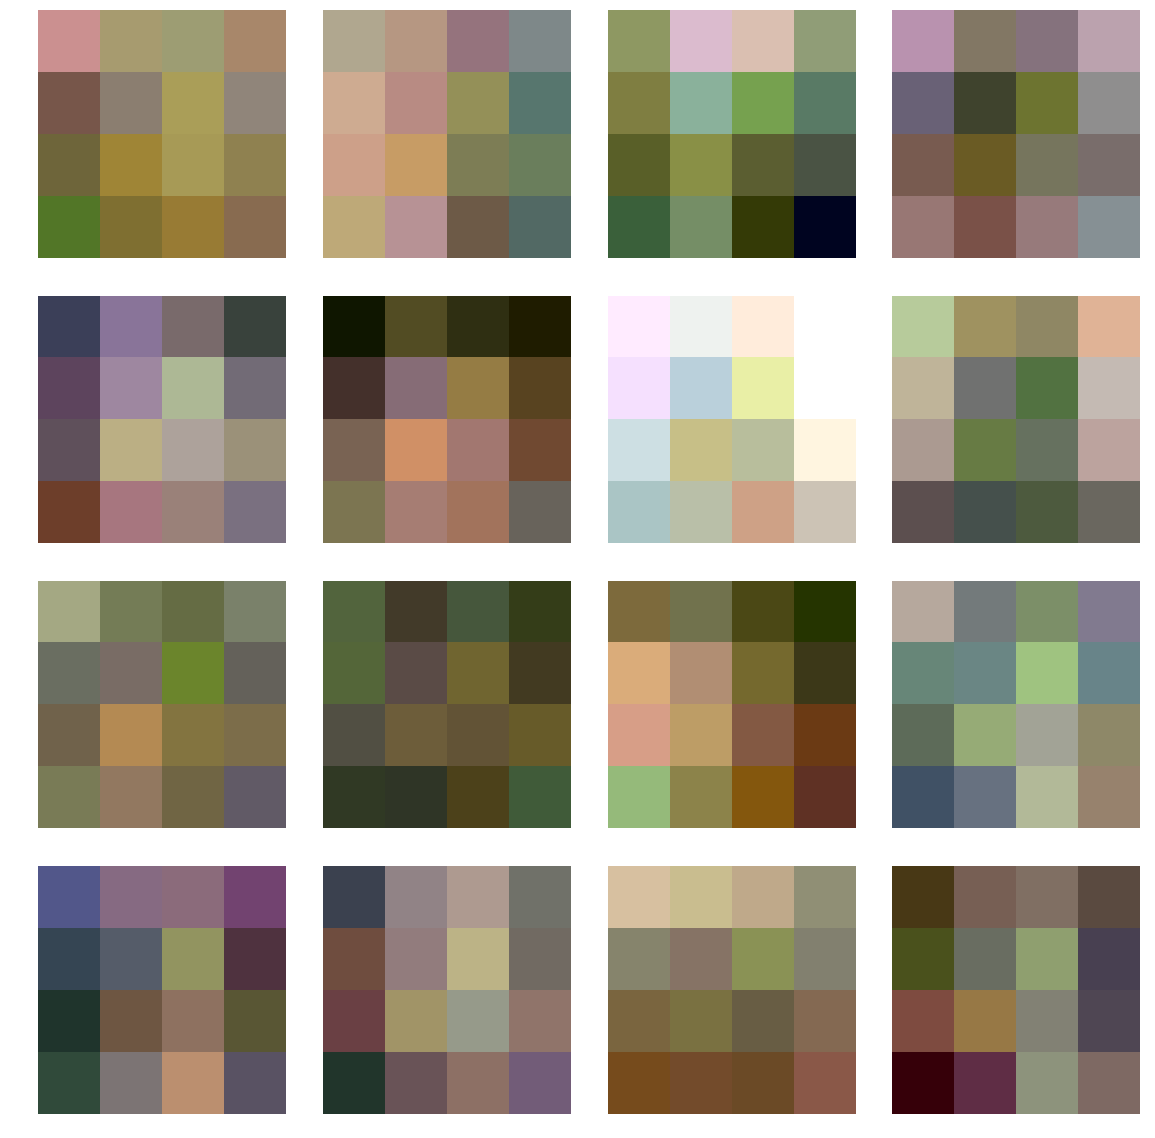

In [30]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(16,16))

In [31]:
data_8 = get_data(128, 8, path/'images_8', 8)

In [32]:
learn.grow_model(data_8, alpha_batch=3125)

In [ ]:
learn.fit(20, 1e-3)

In [34]:
learn.save('stylegan_8')

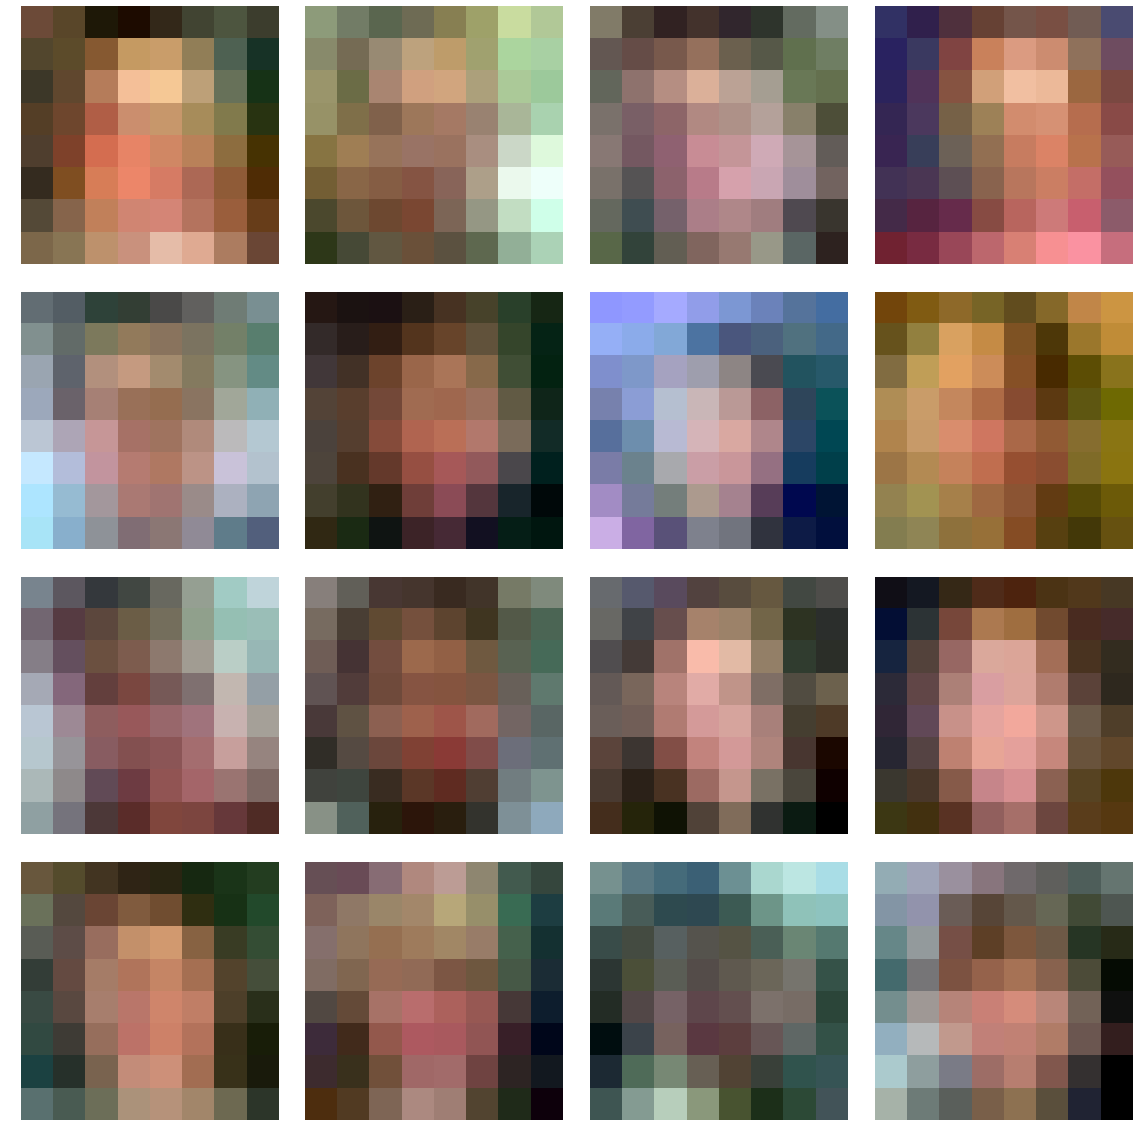

In [35]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(16,16))

In [33]:
data_16 = get_data(64, 16, path/'images_16', 8)

In [34]:
learn.grow_model(data_16, alpha_batch=6250)

In [ ]:
learn.fit(20, 1e-3)

In [39]:
learn.save('stylegan_16')

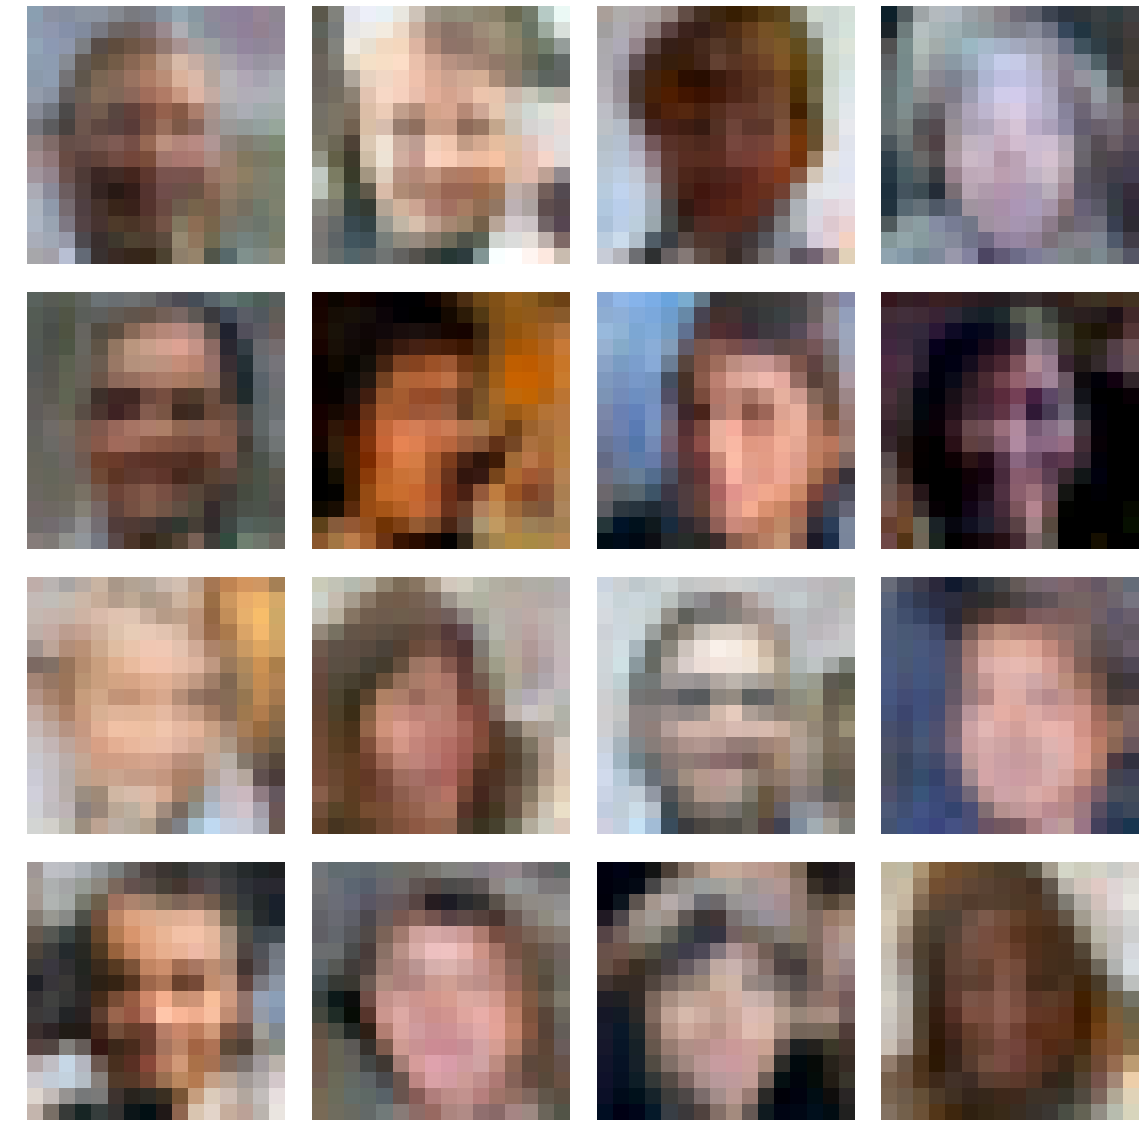

In [40]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(16,16))

In [35]:
data_32 = get_data(32, 32, path/'images_32', 8)

In [36]:
learn.grow_model(data_32, alpha_batch=22000)

In [ ]:
learn.fit(20, 1e-3)

In [44]:
learn.save('stylegan_32')

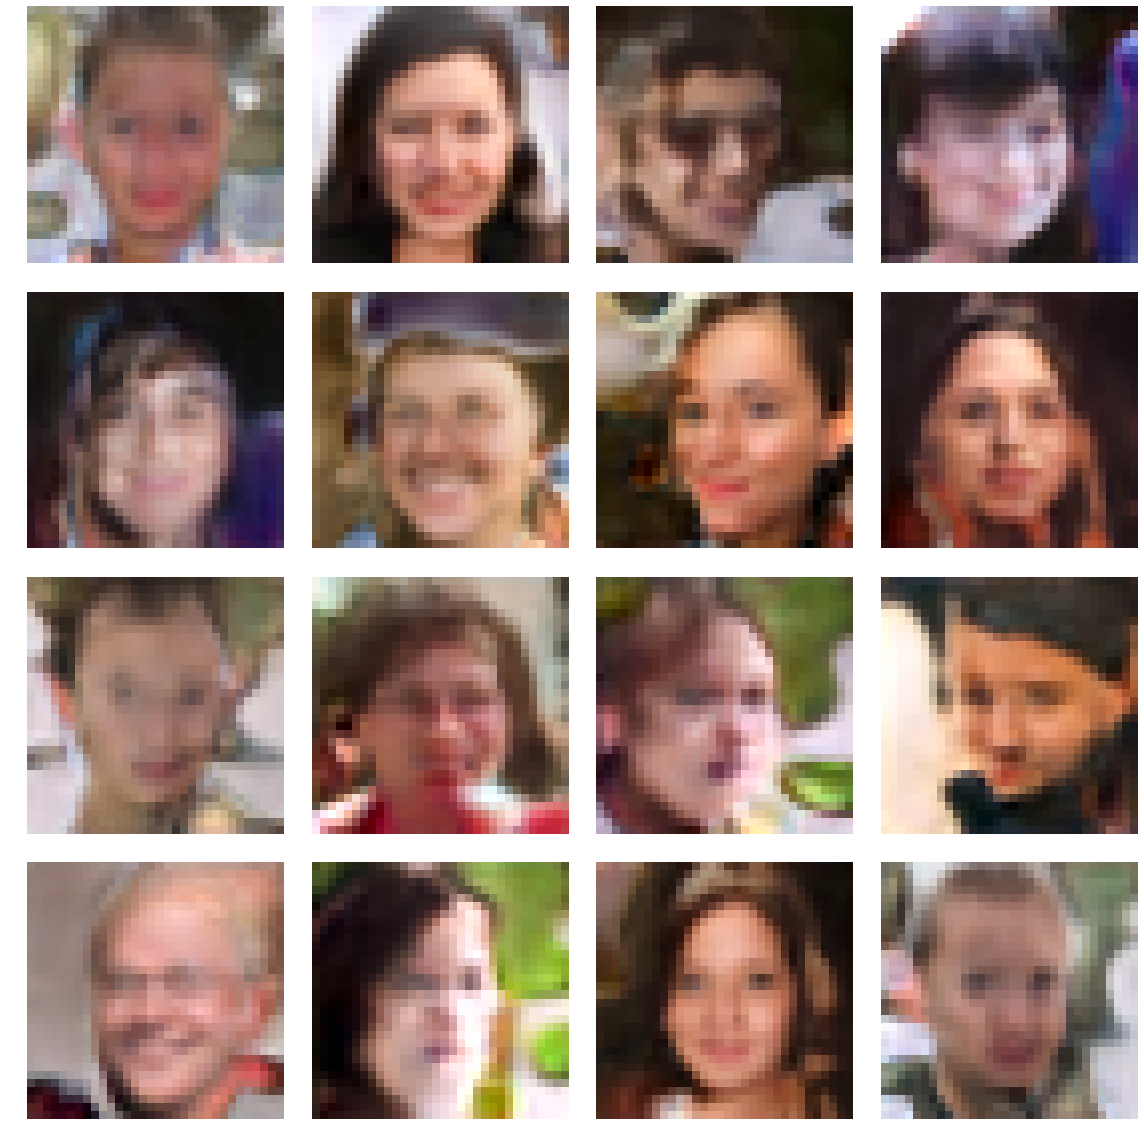

In [45]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(16,16))

In [37]:
data_64 = get_data(32, 64, path/'images_64', 8)

In [38]:
learn.grow_model(data_64, alpha_batch=22000)

In [ ]:
learn.fit(20, 1e-3)

In [39]:
learn.save('stylegan_64')

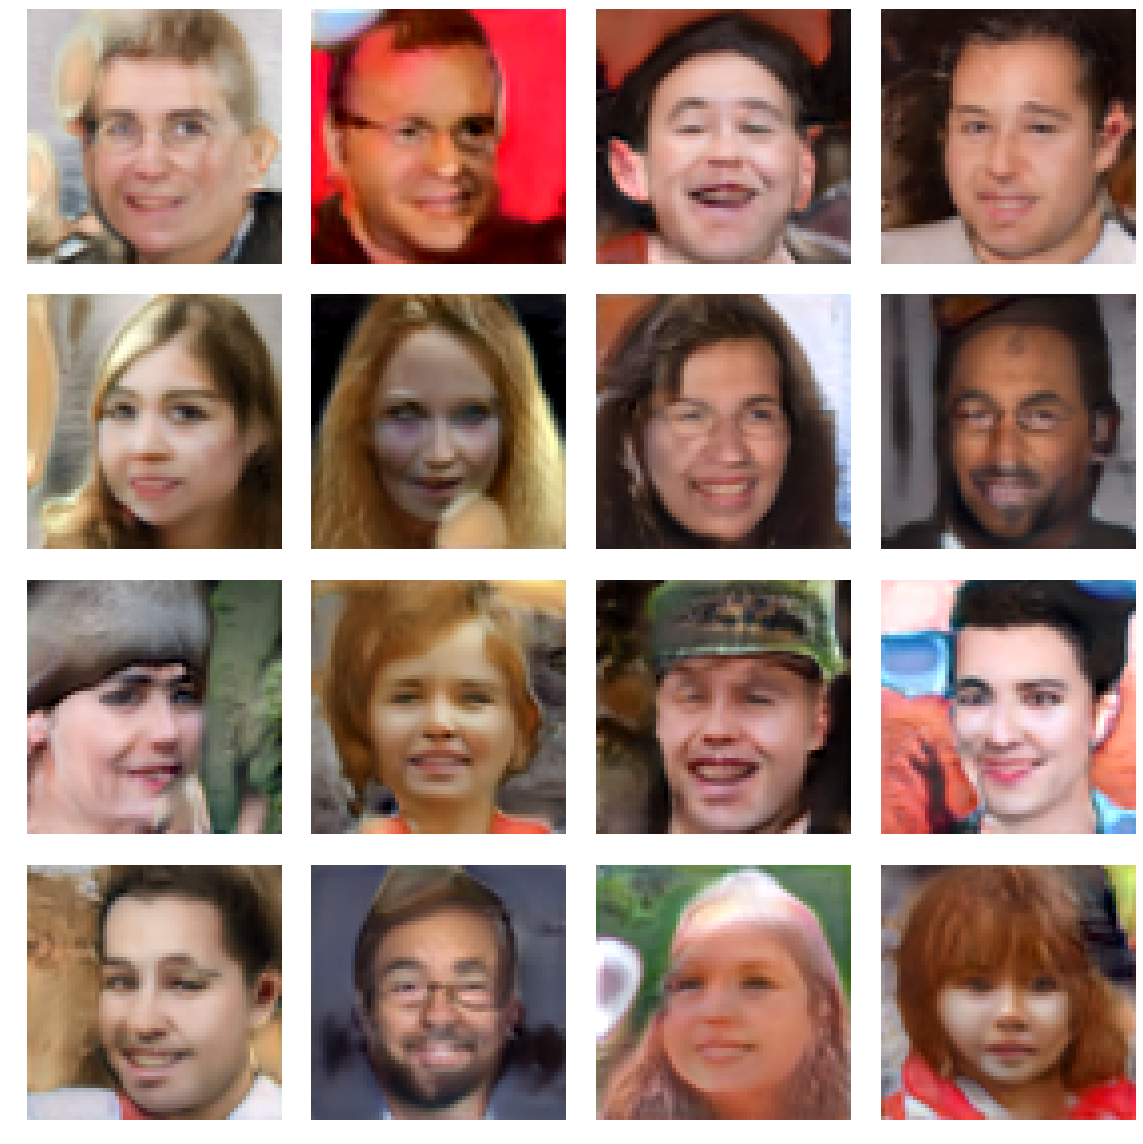

In [40]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(16,16))

In [39]:
data_128 = get_data(22, 128, path/'images_128', 8)

In [41]:
learn.grow_model(data_128, alpha_batch=39000)

In [ ]:
learn.fit(20, 1e-3)

In [44]:
learn.save('stylegan_128')

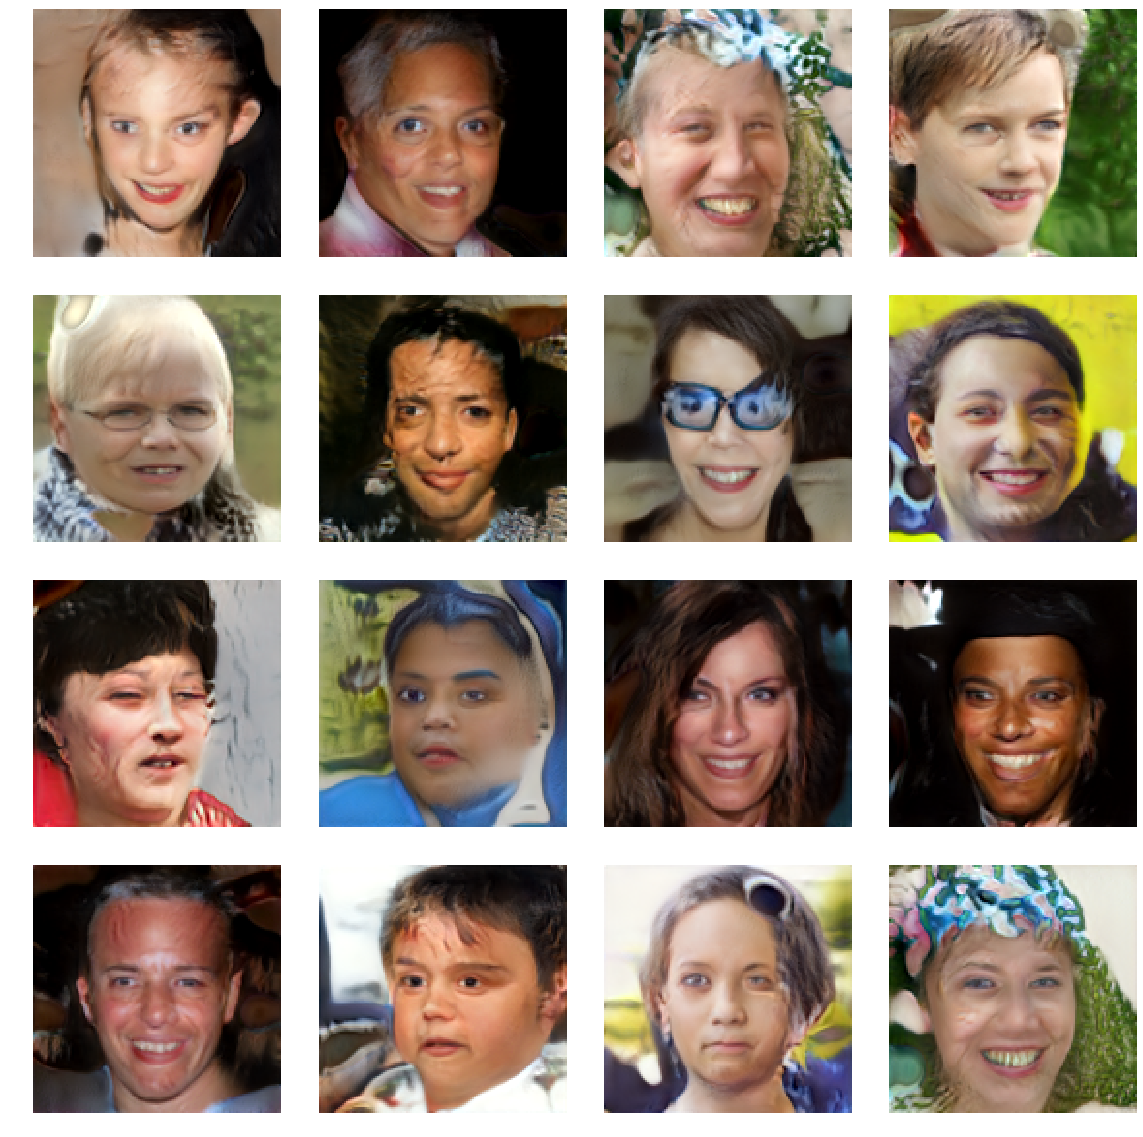

In [45]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(16,16))

In [42]:
data_256 = get_data(10, 256, path/'images_256', 8)

In [44]:
learn.grow_model(data_256, alpha_batch=58000)

In [ ]:
learn.fit(20, 5e-4)